# NLP-project для «N.»  с BERT

## Описание проекта

Интернет-магазин «N.» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
В нашем распоряжении набор данных с разметкой о токсичности правок.

<h1>Содержание<span class="tocSkip"></span></h1><br>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Data-upload-and-prepare" data-toc-modified-id="Data-upload-and-prepare-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data upload and prepare</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>TF-IDF</a></span><ul class="toc-item"><li><span><a href="#TF-IDF-(NLTK-lemmatize)" data-toc-modified-id="TF-IDF-(NLTK-lemmatize)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>TF-IDF (NLTK lemmatize)</a></span></li><li><span><a href="#TF-IDF-(SpaCy-lemmatize)" data-toc-modified-id="TF-IDF-(SpaCy-lemmatize)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>TF-IDF (SpaCy lemmatize)</a></span></li></ul></li><li><span><a href="#BERT" data-toc-modified-id="BERT-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>BERT</a></span><ul class="toc-item"><li><span><a href="#distilbert-base-uncased" data-toc-modified-id="distilbert-base-uncased-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>distilbert-base-uncased</a></span></li><li><span><a href="#bert-base-uncased-fine-tuning" data-toc-modified-id="bert-base-uncased-fine-tuning-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>bert-base-uncased fine tuning</a></span></li><li><span><a href="#toxic-bert" data-toc-modified-id="toxic-bert-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>toxic-bert</a></span></li><li><span><a href="#Detoxify-(toxic-bert-API)" data-toc-modified-id="Detoxify-(toxic-bert-API)-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Detoxify (toxic-bert API)</a></span><ul class="toc-item"><li><span><a href="#original-toxic-bert" data-toc-modified-id="original-toxic-bert-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>original toxic-bert</a></span></li><li><span><a href="#unbiased-toxic-roberta" data-toc-modified-id="unbiased-toxic-roberta-5.4.2"><span class="toc-item-num">5.4.2&nbsp;&nbsp;</span>unbiased-toxic-roberta</a></span></li></ul></li></ul></li><li><span><a href="#Final-model-tuning" data-toc-modified-id="Final-model-tuning-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Final model tuning</a></span></li><li><span><a href="#Final-test" data-toc-modified-id="Final-test-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Final test</a></span></li></ul></div>

## Data upload and prepare

In [1]:
# Загружаем библиотеки
import numpy as np
import pandas as pd
import itertools
import random
import re
from tqdm import notebook

# Визуализации
import matplotlib.pyplot as plt
from plot_metric.functions import BinaryClassification
import seaborn as sns
sns.set_theme(style="darkgrid")

# Лемматизация
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import spacy

# Модели и инструменты
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from catboost import CatBoostClassifier

# Нейронки
import torch
import torch.nn as nn
import transformers
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, Dataset
from detoxify import Detoxify

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# Проверяем доступность GPU
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda")

In [4]:
try:
    df = pd.read_csv(r"C:\Users\dlbol\Downloads\toxic_comments.csv")
except:
    df = pd.read_csv('/Users/david/Downloads/toxic_comments.csv')

In [5]:
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [6]:
df.toxic.value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

В данных имеется естественный сильный дисбаланс классов - в последствии будем пробовать скорректировать предсказания моделей изменением порога бинаризации.

In [7]:
def clear_text(text):
    string = re.sub(r'[^a-zA-Z]', ' ', text) 
    return " ".join(string.split())

# Очищаем корпус текстов от лишних символов
df['text'] = df['text'].apply(clear_text)

In [8]:
def metrics(model, train, y_train, test, y_test, threshold=0):
    proba = model.predict_proba(train)
    proba = proba[:, 1]
    res_f1 = 0
    if threshold == 0:
        # Перебираем значения порога
        for i in np.linspace(0, 1, num=100):
            # Прогнозируем класс на основе выбранного порога
            pred = np.where(proba >= i, 1, 0)
            # Считаем f1 для каждого порога
            f1 = f1_score(y_train, pred)
            # Сохраняем лучший порог по значению f1
            if res_f1 < f1:
                res_f1 = f1
                threshold = i

    proba = model.predict_proba(test)
    proba = proba[:, 1]
    
    # Визуализация
    bc = BinaryClassification(y_test, proba, labels=["Class 0", "Class 1"], threshold=threshold)
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    plt.show()
    
    pred_base = np.where(proba >= 0.5, 1, 0)
    f1_base = f1_score(y_test, pred_base)
    pred = np.where(proba >= threshold, 1, 0)
    res_f1 = f1_score(y_test, pred)
    print(f'Базовое значение F1: {f1_base}')
    print(f'Максимизированное значение F1: {res_f1}')

## Baseline

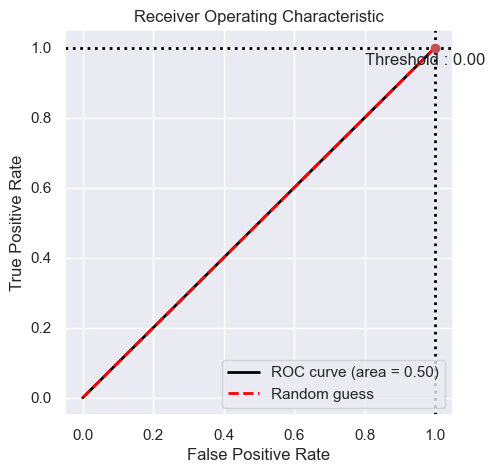

Базовое значение F1: 0.0
Максимизированное значение F1: 0.18260125499144325


In [9]:
train_full, test, y_train_full, y_test = train_test_split(df['toxic'], df['toxic'], test_size=.2, random_state=42)
train, val, y_train, y_val = train_test_split(train_full, y_train_full, test_size=.2, random_state=42)

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train, y_train)
metrics(dummy_clf, train, y_train, test, y_test)

## TF-IDF

### TF-IDF (NLTK lemmatize)

In [10]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dlbol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dlbol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dlbol\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dlbol\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dlbol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
%%time
lemmatizer = WordNetLemmatizer()
corpus = df['text'].apply(
    lambda x: " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)])
)

CPU times: total: 1h 5min 28s
Wall time: 1h 5min 29s


In [12]:
corpus = corpus.values.astype(str)

stopwords = set(nltk_stopwords.words('english'))

tf_idf = TfidfVectorizer(stop_words=stopwords)

train_full, test, y_train_full, y_test = train_test_split(corpus, df['toxic'], test_size=.2, random_state=42)
train, val, y_train, y_val = train_test_split(train_full, y_train_full, test_size=.2, random_state=42)

train = tf_idf.fit_transform(train)
val = tf_idf.transform(val)

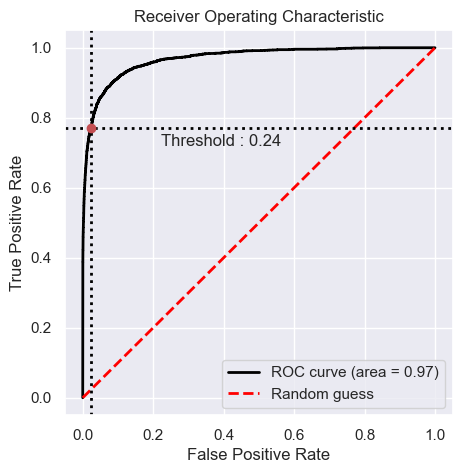

Базовое значение F1: 0.7300541303836197
Максимизированное значение F1: 0.7795275590551181


In [13]:
res_score = 0
for C in list(np.linspace(0.1, 20, 100)) + [1]:
    model = LogisticRegression(C=C).fit(train, y_train)
    pred = model.predict(val)
    score = f1_score(y_val, pred)
    if res_score < score:
        res_score = score
        C_best = C
LogisticRegression(C=C_best).fit(train, y_train)
metrics(model, train, y_train, val, y_val)

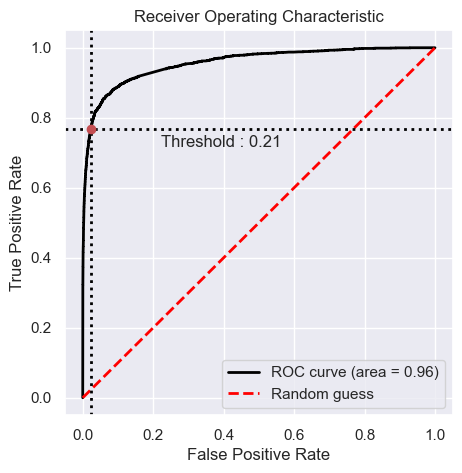

Базовое значение F1: 0.7457240592930445
Максимизированное значение F1: 0.7777121480606417


In [14]:
model = CatBoostClassifier(verbose=False, 
                           eval_metric='F1', 
                           early_stopping_rounds=50,
                           random_state=42)
model.fit(train, y_train, eval_set=(val, y_val))
metrics(model, train, y_train, val, y_val)

### TF-IDF (SpaCy lemmatize)

In [15]:
!python -m spacy download en_core_web_sm

     -------------------------------------- 12.8/12.8 MB 318.4 kB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [16]:
%%time
nlp = spacy.load("en_core_web_sm")
corpus = df['text'].apply(
    lambda x: " ".join([word.lemma_ for word in nlp(clear_text(x))])
)

CPU times: total: 32min 2s
Wall time: 32min 3s


In [17]:
corpus = corpus.values.astype(str)

stopwords = set(nltk_stopwords.words('english'))

tf_idf = TfidfVectorizer(stop_words=stopwords)

train_full, test, y_train_full, y_test = train_test_split(corpus, df['toxic'], test_size=.2, random_state=42)
train, val, y_train, y_val = train_test_split(train_full, y_train_full, test_size=.2, random_state=42)

train = tf_idf.fit_transform(train)
val = tf_idf.transform(val)

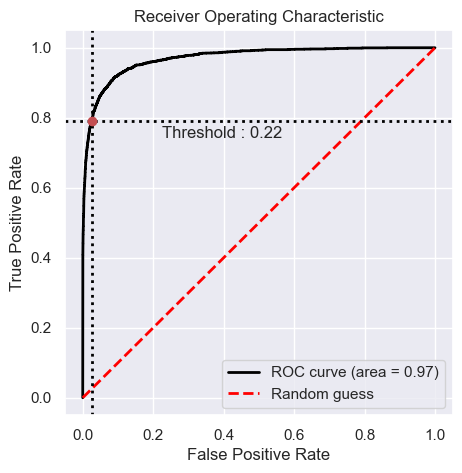

Базовое значение F1: 0.7347417840375587
Максимизированное значение F1: 0.7832948421862972


In [18]:
res_score = 0
for C in list(np.linspace(0.1, 20, 100)) + [1]:
    model = LogisticRegression(C=C).fit(train, y_train)
    pred = model.predict(val)
    score = f1_score(y_val, pred)
    if res_score < score:
        res_score = score
        C_best = C
LogisticRegression(C=C_best).fit(train, y_train)
metrics(model, train, y_train, val, y_val)

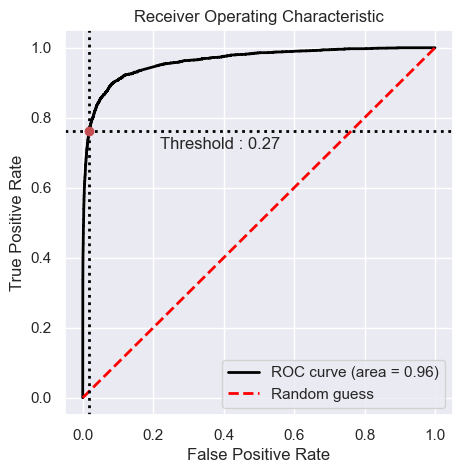

Базовое значение F1: 0.7656425207445616
Максимизированное значение F1: 0.7914395315970119


In [19]:
model = CatBoostClassifier(verbose=False, 
                           eval_metric='F1', 
                           early_stopping_rounds=50,
                           random_state=42)
model.fit(train, y_train, eval_set=(val, y_val))
metrics(model, train, y_train, val, y_val)

## BERT

### distilbert-base-uncased

In [65]:
%%time
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: total: 562 ms
Wall time: 1.57 s


In [66]:
%%time
tokenized = df['text'].apply(lambda x: tokenizer.encode(x, 
                                                        max_length=512,
                                                        padding='max_length',
                                                        truncation=True,
                                                        add_special_tokens=True)
                            )

CPU times: total: 28.9 s
Wall time: 28.9 s


In [73]:
tokenized = np.array(list(tokenized))

In [74]:
attention_mask = np.where(tokenized != 0, 1, 0)

In [76]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(tokenized.shape[0] // batch_size)):
    slice_top = batch_size*(i+1)
    if slice_top == 159200:
        slice_top = tokenized.shape[0]
    batch = torch.LongTensor(tokenized[batch_size*i:slice_top])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:slice_top])
    batch = batch.to(device)
    attention_mask_batch = attention_mask_batch.to(device)
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    batch_embeddings = batch_embeddings[0][:,0,:].to('cpu')
    embeddings.append(batch_embeddings.numpy())

  0%|          | 0/1592 [00:00<?, ?it/s]

In [77]:
features = np.concatenate(embeddings)

In [78]:
train_full, test, y_train_full, y_test = train_test_split(features, df['toxic'], test_size=.2, random_state=42)
train, val, y_train, y_val = train_test_split(train_full, y_train_full, test_size=.25, random_state=42)

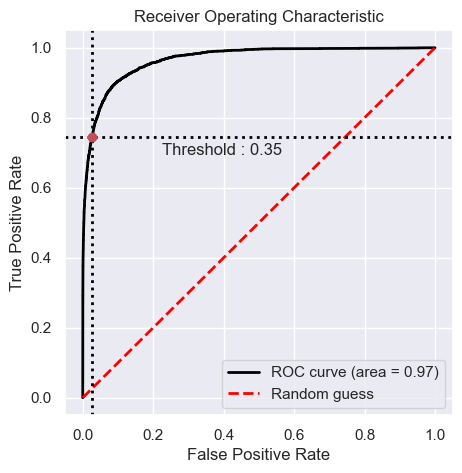

Базовое значение F1: 0.7477079796264856
Максимизированное значение F1: 0.7552252670692058


In [79]:
res_score = 0
for C in list(np.linspace(0.1, 20, 100)) + [1]:
    model = LogisticRegression(C=C).fit(train, y_train)
    pred = model.predict(val)
    score = f1_score(y_val, pred)
    if res_score < score:
        res_score = score
        C_best = C
LogisticRegression(C=C_best).fit(train, y_train)
metrics(model, train, y_train, val, y_val)

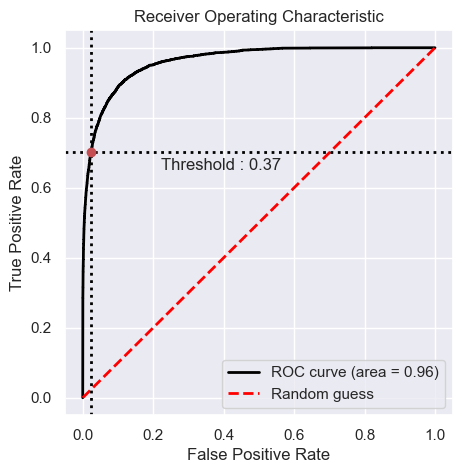

Базовое значение F1: 0.722761970853574
Максимизированное значение F1: 0.7379730596536241


In [80]:
model = CatBoostClassifier(verbose=False, 
                           eval_metric='F1', 
                           early_stopping_rounds=50,
                           random_state=42)
model.fit(train, y_train, eval_set=(val, y_val))
metrics(model, train, y_train, val, y_val)

### bert-base-uncased fine tuning

In [9]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

In [10]:
train, test = train_test_split(df, test_size=.2, random_state=42)
train, val = train_test_split(train, test_size=.25, random_state=42)
train_text = train['text'].astype('str')
train_labels = train['toxic']
val_text = val['text'].astype('str')
val_labels = val['toxic']

In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
%%time
tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = 512,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.values,
    max_length = 512,
    padding = 'max_length',
    truncation = True
)

CPU times: total: 1min 28s
Wall time: 1min 28s


In [14]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)
    
train_dataset = Data(tokens_train, train_labels.values)
val_dataset = Data(tokens_val, val_labels.values)

In [15]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    return {'F1': f1}

In [16]:
training_args = TrainingArguments(
    output_dir = './results', #Выходной каталог
    num_train_epochs = 3, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay =0.01, #Понижение весов
    logging_dir = './logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 1e-5, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=42)

In [17]:
trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = train_dataset,
                  compute_metrics = compute_metrics)

In [18]:
%%time
trainer.train()

***** Running training *****
  Num examples = 95574
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35841
  Number of trainable parameters = 109483778


Epoch,Training Loss,Validation Loss,F1
1,0.129300,0.071622,0.893682
2,0.081000,0.032944,0.957615
3,0.043200,0.017305,0.979880


***** Running Evaluation *****
  Num examples = 95574
  Batch size = 8
Saving model checkpoint to ./results\checkpoint-11947
Configuration saved in ./results\checkpoint-11947\config.json
Model weights saved in ./results\checkpoint-11947\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-11947\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-11947\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 95574
  Batch size = 8
Saving model checkpoint to ./results\checkpoint-23894
Configuration saved in ./results\checkpoint-23894\config.json
Model weights saved in ./results\checkpoint-23894\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-23894\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-23894\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 95574
  Batch size = 8
Saving model checkpoint to ./results\checkpoint-35841
Configuration saved in ./results\checkpoint-3

CPU times: total: 3h 45min 1s
Wall time: 4h 51min 2s


TrainOutput(global_step=35841, training_loss=0.08448820581646631, metrics={'train_runtime': 17462.4882, 'train_samples_per_second': 16.419, 'train_steps_per_second': 2.052, 'total_flos': 7.543972801492992e+16, 'train_loss': 0.08448820581646631, 'epoch': 3.0})

In [19]:
def get_prediction():
    val_pred = trainer.predict(val_dataset)
    labels = np.argmax(val_pred.predictions, axis = -1)
    return labels
pred = get_prediction()

***** Running Prediction *****
  Num examples = 31859
  Batch size = 8


In [22]:
print(classification_report(val_labels, pred))
print(f'F1:{f1_score(val_labels, pred)}')

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     28581
           1       0.85      0.84      0.84      3278

    accuracy                           0.97     31859
   macro avg       0.91      0.91      0.91     31859
weighted avg       0.97      0.97      0.97     31859

F1:0.8426707597851114


### toxic-bert

In [9]:
%%time
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")

model = AutoModel.from_pretrained("unitary/toxic-bert").to(device)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: total: 922 ms
Wall time: 1.98 s


In [10]:
%%time
tokenized = df['text'].apply(lambda x: tokenizer.encode(x, 
                                                        max_length=512,
                                                        padding='max_length',
                                                        truncation=True,
                                                        add_special_tokens=True)
                            )
tokenized = np.array(list(tokenized))

CPU times: total: 34.6 s
Wall time: 34.7 s


In [11]:
attention_mask = np.where(tokenized != 0, 1, 0)

In [12]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(tokenized.shape[0] // batch_size)):
    slice_top = batch_size*(i+1)
    if slice_top == 159200:
        slice_top = tokenized.shape[0]
    batch = torch.LongTensor(tokenized[batch_size*i:slice_top])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:slice_top])
    batch = batch.to(device)
    attention_mask_batch = attention_mask_batch.to(device)
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    batch_embeddings = batch_embeddings[0][:,0,:].to('cpu')
    embeddings.append(batch_embeddings.numpy())

  0%|          | 0/1592 [00:00<?, ?it/s]

In [13]:
features = np.concatenate(embeddings)

In [14]:
train_full, test, y_train_full, y_test = train_test_split(features, df['toxic'], test_size=.2, random_state=42)
train, val, y_train, y_val = train_test_split(train_full, y_train_full, test_size=.25, random_state=42)

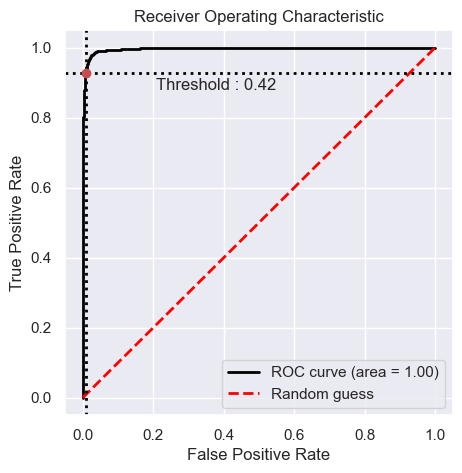

Базовое значение F1: 0.9240233774223316
Максимизированное значение F1: 0.9251328777524677


In [15]:
res_score = 0
for C in list(np.linspace(0.1, 20, 100)) + [1]:
    model = LogisticRegression(C=C).fit(train, y_train)
    pred = model.predict(val)
    score = f1_score(y_val, pred)
    if res_score < score:
        res_score = score
        C_best = C
LogisticRegression(C=C_best).fit(train, y_train)
metrics(model, train, y_train, val, y_val)

In [16]:
depth = [None, 6, 8, 10]
l2_leaf_reg = [None, 0.1, 1, 10]
random_strength = [None, 0.1, 1, 10]
bagging_temperature = [None, 0.1, 1, 10]
params_list = list(itertools.product(depth, l2_leaf_reg, random_strength, bagging_temperature))
res_score = 0
for depth, l2_leaf_reg, random_strength, bagging_temperature in notebook.tqdm(params_list):
    model = CatBoostClassifier(verbose=False, 
                               eval_metric='F1', 
                               early_stopping_rounds=50,
                               depth=depth,
                               l2_leaf_reg=l2_leaf_reg,
                               random_strength=random_strength,
                               bagging_temperature=bagging_temperature,
                               random_state=42)
    model.fit(train, y_train, eval_set=(val, y_val))
    score = model.best_score_['validation']['F1']
    if res_score < score:
        res_score = score
        params = depth, l2_leaf_reg, random_strength, bagging_temperature
print(res_score, params)

  0%|          | 0/256 [00:00<?, ?it/s]

0.9272727272727272 (10, 10, 0.1, None)


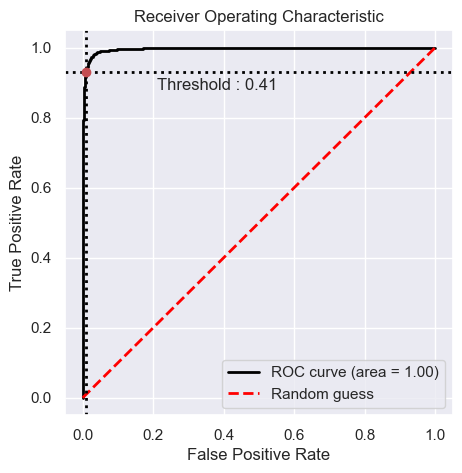

Базовое значение F1: 0.9253869969040247
Максимизированное значение F1: 0.9240333586050038


In [17]:
params = depth, l2_leaf_reg, random_strength, bagging_temperature 
model = CatBoostClassifier(verbose=False, 
                           eval_metric='F1', 
                           early_stopping_rounds=50,
                           depth=depth,
                           l2_leaf_reg=l2_leaf_reg,
                           random_strength=random_strength,
                           bagging_temperature=bagging_temperature,
                           random_state=42)
model.fit(train, y_train, eval_set=(val, y_val))
metrics(model, train, y_train, val, y_val)

### Detoxify (toxic-bert API)

#### original toxic-bert

In [10]:
train_full, test, y_train_full, y_test = train_test_split(df['text'], df['toxic'], test_size=.2, random_state=42)

model = Detoxify('original', device=device)

In [11]:
batch_size = 100
for i in notebook.tqdm(range(train_full.shape[0] // batch_size)):
    slice_top = batch_size*(i+1)
    if slice_top == 127400:
        slice_top = train_full.shape[0]
    batch = list(train_full[batch_size*i:slice_top])
    result = model.predict(batch)
    result = pd.DataFrame(result)
    if i == 0:
        results = result
    else:
        results = pd.concat([results, result])

  0%|          | 0/1274 [00:00<?, ?it/s]

In [12]:
results = results.reset_index(drop=True)
results

,toxicity,severe_toxicity,obscene,threat,insult,identity_attack
0,0.043573,0.000111,0.000775,0.000330,0.002128,0.000325
1,0.000946,0.000109,0.000174,0.000148,0.000192,0.000144
2,0.000836,0.000107,0.000174,0.000113,0.000181,0.000138
3,0.000683,0.000115,0.000174,0.000122,0.000183,0.000141
4,0.000953,0.000102,0.000175,0.000121,0.000185,0.000139
...,...,...,...,...,...,...
127428,0.002020,0.000088,0.000216,0.000124,0.000231,0.000151
127429,0.593819,0.003748,0.011355,0.002950,0.033266,0.222529
127430,0.003698,0.000088,0.000264,0.000110,0.000247,0.000211
127431,0.001174,0.000103,0.000195,0.000140,0.000189,0.000143


In [13]:
train, val, y_train, y_val = train_test_split(results, y_train_full, test_size=.2, random_state=42)

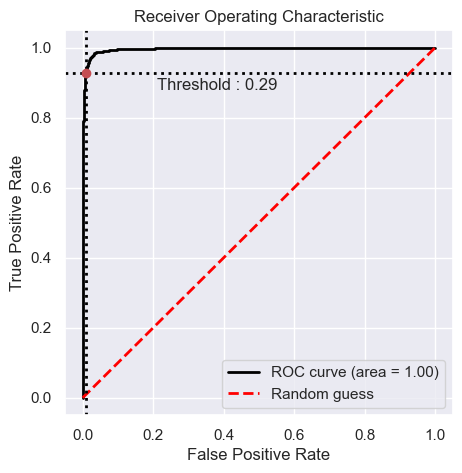

Базовое значение F1: 0.9217081850533808
Максимизированное значение F1: 0.9223938223938224


In [14]:
res_score = 0
for C in list(np.linspace(0.1, 20, 100)) + [1]:
    model = LogisticRegression(C=C).fit(train, y_train)
    pred = model.predict(val)
    score = f1_score(y_val, pred)
    if res_score < score:
        res_score = score
        C_best = C
LogisticRegression(C=C_best).fit(train, y_train)
metrics(model, train, y_train, val, y_val)

In [15]:
depth = [None, 6, 8, 10]
l2_leaf_reg = [None, 0.1, 1, 10]
random_strength = [None, 0.1, 1, 10]
bagging_temperature = [None, 0.1, 1, 10]
params_list = list(itertools.product(depth, l2_leaf_reg, random_strength, bagging_temperature))
res_score = 0
for depth, l2_leaf_reg, random_strength, bagging_temperature in notebook.tqdm(params_list):
    model = CatBoostClassifier(verbose=False, 
                               eval_metric='F1', 
                               early_stopping_rounds=50,
                               depth=depth,
                               l2_leaf_reg=l2_leaf_reg,
                               random_strength=random_strength,
                               bagging_temperature=bagging_temperature,
                               random_state=42)
    model.fit(train, y_train, eval_set=(val, y_val))
    score = model.best_score_['validation']['F1']
    if res_score < score:
        res_score = score
        params = depth, l2_leaf_reg, random_strength, bagging_temperature
print(res_score, params)

  0%|          | 0/256 [00:00<?, ?it/s]

0.9261876717707106 (None, 1, 10, None)


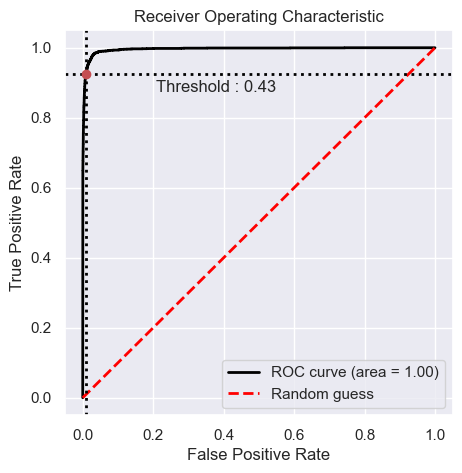

Базовое значение F1: 0.9253087629876495
Максимизированное значение F1: 0.923495145631068


In [16]:
params = depth, l2_leaf_reg, random_strength, bagging_temperature 
model = CatBoostClassifier(verbose=False, 
                           eval_metric='F1', 
                           early_stopping_rounds=50,
                           depth=depth,
                           l2_leaf_reg=l2_leaf_reg,
                           random_strength=random_strength,
                           bagging_temperature=bagging_temperature,
                           random_state=42)
model.fit(train, y_train, eval_set=(val, y_val))
metrics(model, train, y_train, val, y_val)

#### unbiased-toxic-roberta

In [17]:
model = Detoxify('unbiased', device=device)

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.3-alpha/toxic_debiased-c7548aa0.ckpt" to C:\Users\dlbol/.cache\torch\hub\checkpoints\toxic_debiased-c7548aa0.ckpt


  0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [18]:
batch_size = 100
for i in notebook.tqdm(range(train_full.shape[0] // batch_size)):
    slice_top = batch_size*(i+1)
    if slice_top == 127400:
        slice_top = train_full.shape[0]
    batch = list(train_full[batch_size*i:slice_top])
    result = model.predict(batch)
    result = pd.DataFrame(result)
    if i == 0:
        results = result
    else:
        results = pd.concat([results, result])

  0%|          | 0/1274 [00:00<?, ?it/s]

In [19]:
results = results.reset_index(drop=True)
results

,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,0.073630,0.000004,0.000550,0.000423,0.042458,0.000061,0.000094
1,0.002156,0.000010,0.000197,0.000208,0.000087,0.000080,0.000131
2,0.000777,0.000002,0.000027,0.000216,0.000152,0.000035,0.000019
3,0.000549,0.000001,0.000030,0.000092,0.000136,0.000020,0.000017
4,0.002835,0.000003,0.000176,0.000202,0.000827,0.000082,0.000031
...,...,...,...,...,...,...,...
127428,0.003045,0.000007,0.000201,0.000229,0.000182,0.000049,0.000100
127429,0.558861,0.000826,0.003415,0.679762,0.031679,0.003011,0.012804
127430,0.004644,0.000003,0.000129,0.000324,0.000965,0.000081,0.000040
127431,0.000990,0.000005,0.000120,0.000126,0.000096,0.000024,0.000049


In [20]:
train, val, y_train, y_val = train_test_split(results, y_train_full, test_size=.2, random_state=42)

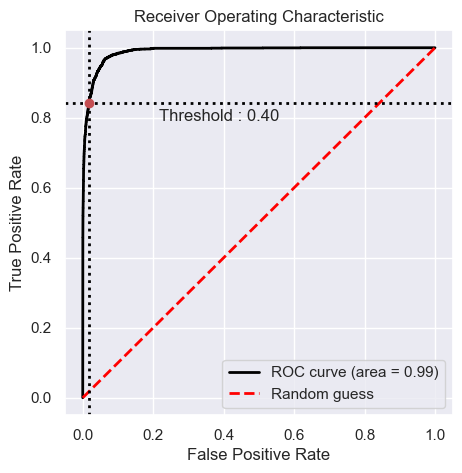

Базовое значение F1: 0.8409317141150707
Максимизированное значение F1: 0.8424537487828626


In [21]:
res_score = 0
for C in list(np.linspace(0.1, 20, 100)) + [1]:
    model = LogisticRegression(C=C).fit(train, y_train)
    pred = model.predict(val)
    score = f1_score(y_val, pred)
    if res_score < score:
        res_score = score
        C_best = C
LogisticRegression(C=C_best).fit(train, y_train)
metrics(model, train, y_train, val, y_val)

## Final model tuning

Наилучшие результаты показала предобученная модель toxic-bert. Так как ее использование напрямую из библиотеки https://github.com/unitaryai/detoxify наиболее удобно и экономично повремени будем использовать ее так.

In [23]:
train_full, test, y_train_full, y_test = train_test_split(df['text'], df['toxic'], test_size=.2, random_state=42)

model = Detoxify('original', device=device)

In [24]:
batch_size = 100
for i in notebook.tqdm(range(train_full.shape[0] // batch_size)):
    slice_top = batch_size*(i+1)
    if slice_top == 127400:
        slice_top = train_full.shape[0]
    batch = list(train_full[batch_size*i:slice_top])
    result = model.predict(batch)
    result = pd.DataFrame(result)
    if i == 0:
        results = result
    else:
        results = pd.concat([results, result])

  0%|          | 0/1274 [00:00<?, ?it/s]

In [25]:
results = results.reset_index(drop=True)
results

,toxicity,severe_toxicity,obscene,threat,insult,identity_attack
0,0.043573,0.000111,0.000775,0.000330,0.002128,0.000325
1,0.000946,0.000109,0.000174,0.000148,0.000192,0.000144
2,0.000836,0.000107,0.000174,0.000113,0.000181,0.000138
3,0.000683,0.000115,0.000174,0.000122,0.000183,0.000141
4,0.000953,0.000102,0.000175,0.000121,0.000185,0.000139
...,...,...,...,...,...,...
127428,0.002020,0.000088,0.000216,0.000124,0.000231,0.000151
127429,0.593819,0.003748,0.011355,0.002950,0.033266,0.222529
127430,0.003698,0.000088,0.000264,0.000110,0.000247,0.000211
127431,0.001174,0.000103,0.000195,0.000140,0.000189,0.000143


In [26]:
train, val, y_train, y_val = train_test_split(results, y_train_full, test_size=.2, random_state=42)

In [28]:
l2_leaf_reg = [0.5, 1, 2, 5]
random_strength = [5, 10, 20, 50]
params_list = list(itertools.product(l2_leaf_reg, random_strength))
res_score = 0
for l2_leaf_reg, random_strength in notebook.tqdm(params_list):
    model = CatBoostClassifier(verbose=False,
                               eval_metric='F1',
                               early_stopping_rounds=50,
                               l2_leaf_reg=l2_leaf_reg,
                               random_strength=random_strength,
                               random_state=42)
    model.fit(train, y_train, eval_set=(val, y_val))
    score = model.best_score_['validation']['F1']
    if res_score < score:
        res_score = score
        params = l2_leaf_reg, random_strength, model.best_iteration_, model.learning_rate_
print(res_score, params)

  0%|          | 0/16 [00:00<?, ?it/s]

0.9261876717707106 (1, 10, 211, 0.029999999329447746)


## Final test

In [42]:
model = Detoxify('original', device=device)

In [43]:
batch_size = 100
for i in notebook.tqdm(range(test.shape[0] // batch_size)):
    slice_top = batch_size*(i+1)
    if slice_top == test.shape[0] // 100 *100:
        slice_top = test.shape[0]
    batch = list(test[batch_size*i:slice_top])
    test_result = model.predict(batch)
    test_result = pd.DataFrame(test_result)
    if i == 0:
        test_results = test_result
    else:
        test_results = pd.concat([test_results, test_result])

  0%|          | 0/318 [00:00<?, ?it/s]

In [44]:
test_results = test_results.reset_index(drop=True)
test_results

,toxicity,severe_toxicity,obscene,threat,insult,identity_attack
0,0.000682,0.000117,0.000179,0.000132,0.000177,0.000135
1,0.001052,0.000098,0.000178,0.000111,0.000184,0.000136
2,0.000800,0.000109,0.000159,0.000123,0.000188,0.000147
3,0.000637,0.000117,0.000177,0.000126,0.000171,0.000136
4,0.000674,0.000116,0.000178,0.000130,0.000181,0.000138
...,...,...,...,...,...,...
31854,0.009713,0.000132,0.000470,0.000457,0.000429,0.000345
31855,0.000610,0.000120,0.000181,0.000128,0.000175,0.000136
31856,0.112581,0.000402,0.001045,0.001334,0.002768,0.011407
31857,0.296090,0.000236,0.004244,0.000763,0.021499,0.000999


In [46]:
l2_leaf_reg, random_strength, iterations, learning_rate = params
finalizer = CatBoostClassifier(verbose=100, 
                               l2_leaf_reg=l2_leaf_reg,
                               random_strength=random_strength,
                               iterations=iterations,
                               learning_rate=learning_rate,
                               random_state=42)
finalizer.fit(results, y_train_full)

0:	learn: 0.5929646	total: 13.1ms	remaining: 2.74s
100:	learn: 0.0440472	total: 1.1s	remaining: 1.2s
200:	learn: 0.0426416	total: 2.18s	remaining: 108ms
210:	learn: 0.0425889	total: 2.29s	remaining: 0us


In [47]:
pred = finalizer.predict(test_results)
print(classification_report(y_test, pred))
print()
print(f'Final F1 metrics:{f1_score(y_test, pred)}')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     28658
           1       0.92      0.91      0.92      3201

    accuracy                           0.98     31859
   macro avg       0.96      0.95      0.96     31859
weighted avg       0.98      0.98      0.98     31859


Final F1 metrics:0.9194536033914272


Финальная метрика F1 - 0.92, ее показала предобученная модель toxic-bert с финализирующим оптимизированным градиентным бустингом.